Acknowledgement: This code was initially inspired by the lab "COMP34212_Lab2b_Keras_CNN_CIFAR_2025" before undergoing significant changes.

# Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, Add
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print('Libraries imported.')

Libraries imported.


# Data Preperation

In [ ]:



cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

cifar100_coarse_labels = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
    'trees', 'vehicles 1', 'vehicles 2'
]


fine_to_coarse_mapping = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7,
    8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11,
    16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10,
    24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0, 31: 11,
    32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5,
    40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17,
    48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0,
    56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
    64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10,
    72: 0, 73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13,
    80: 16, 81: 18, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5,
    88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0,
    96: 17, 97: 8, 98: 14, 99: 13
}

In [ ]:

BATCH_SIZE = 256
N_EPOCH = 50
N_CLASSES = 100
N_SUPERCLASSES = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')


IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')


Main variables initialised.
Image variables initialisation


In [ ]:

(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data(label_mode='fine')
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')


output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES)


input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Sample input image class: apple


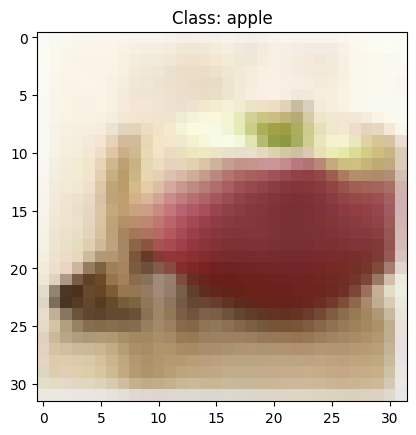

Sample input image class: boy


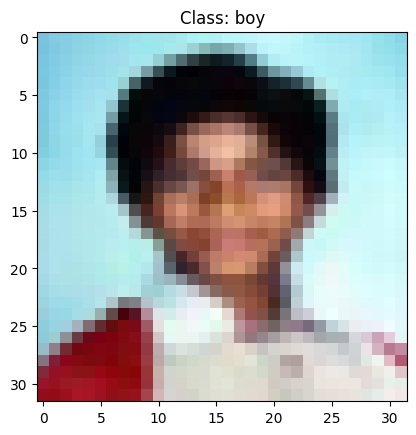

In [ ]:

Selected_Image = 2
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

Selected_Image = 3
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

# Training

In [ ]:
def identity_block(x, filters):
    x_skip = x


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)


    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:
def conv_block(x, filters, stride):
    x_skip = x


    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)


    x_skip = Conv2D(filters, 1, strides=stride, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:

inputs = Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))


x = Conv2D(64, 3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)




x = conv_block(x, 64, stride=1)
x = identity_block(x, 64)


x = conv_block(x, 128, stride=2)
x = identity_block(x, 128)


x = conv_block(x, 256, stride=2)
x = identity_block(x, 256)


x = conv_block(x, 512, stride=2)
x = identity_block(x, 512)



x = GlobalAveragePooling2D()(x)
outputs = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch+1}")
        print(f"LR: {lr:.1e}\n")
        print(f"  Training Loss: {logs['loss']:.4f} - Training Accuracy: {logs['accuracy']:.4f}")
        print(f"  Validation Loss: {logs['val_loss']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")
        if logs['accuracy'] - logs['val_accuracy'] > 0.15:
            print(f"! Overfitting: {logs['accuracy']-logs['val_accuracy']:.4f} gap")



In [ ]:

OPTIM1 = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 11,238,948 (42.87 MB)

 Trainable params: 11,229,220 (42.84 MB)

 Non-trainable params: 9,728 (38.00 KB)

In [ ]:

early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=8,
    restore_best_weights=True,
    start_from_epoch=10
)

In [ ]:

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    input_X_train, output_Y_train,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCH,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        early_stop,
        checkpoint,
        TrainingMonitor(),
    ]
)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0692 - loss: 4.3617
Epoch 1: val_accuracy improved from -inf to 0.01260, saving model to best_model.h5



Epoch 1
LR: 1.0e-03

  Training Loss: 3.9029 - Training Accuracy: 0.1106
  Validation Loss: 6.4402 - Validation Accuracy: 0.0126
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.0695 - loss: 4.3588 - val_accuracy: 0.0126 - val_loss: 6.4402
Epoch 2/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2131 - loss: 3.2175
Epoch 2: val_accuracy improved from 0.01260 to 0.02800, saving model to best_model.h5



Epoch 2
LR: 1.0e-03

  Training Loss: 3.0553 - Training Accuracy: 0.2398
  Validation Loss: 6.3911 - Validation Accuracy: 0.0280
! Overfitting: 0.2118 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.2136 - loss: 3.2144 - val_accuracy: 0.0280 - val_loss: 6.3911
Epoch 3/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3308 - loss: 2.5897
Epoch 3: val_accuracy improved from 0.02800 to 0.14760, saving model to best_model.h5



Epoch 3
LR: 1.0e-03

  Training Loss: 2.4854 - Training Accuracy: 0.3511
  Validation Loss: 3.9969 - Validation Accuracy: 0.1476
! Overfitting: 0.2035 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3312 - loss: 2.5877 - val_accuracy: 0.1476 - val_loss: 3.9969
Epoch 4/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4308 - loss: 2.1087
Epoch 4: val_accuracy improved from 0.14760 to 0.17900, saving model to best_model.h5



Epoch 4
LR: 1.0e-03

  Training Loss: 2.0521 - Training Accuracy: 0.4453
  Validation Loss: 4.5774 - Validation Accuracy: 0.1790
! Overfitting: 0.2663 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4311 - loss: 2.1076 - val_accuracy: 0.1790 - val_loss: 4.5774
Epoch 5/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5151 - loss: 1.7505
Epoch 5: val_accuracy improved from 0.17900 to 0.26190, saving model to best_model.h5



Epoch 5
LR: 1.0e-03

  Training Loss: 1.7182 - Training Accuracy: 0.5213
  Validation Loss: 3.2865 - Validation Accuracy: 0.2619
! Overfitting: 0.2594 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5152 - loss: 1.7499 - val_accuracy: 0.2619 - val_loss: 3.2865
Epoch 6/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5964 - loss: 1.3927
Epoch 6: val_accuracy improved from 0.26190 to 0.28010, saving model to best_model.h5



Epoch 6
LR: 1.0e-03

  Training Loss: 1.4010 - Training Accuracy: 0.5962
  Validation Loss: 3.5410 - Validation Accuracy: 0.2801
! Overfitting: 0.3161 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5964 - loss: 1.3928 - val_accuracy: 0.2801 - val_loss: 3.5410
Epoch 7/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6775 - loss: 1.1005
Epoch 7: val_accuracy improved from 0.28010 to 0.30920, saving model to best_model.h5



Epoch 7
LR: 1.0e-03

  Training Loss: 1.0995 - Training Accuracy: 0.6742
  Validation Loss: 3.2163 - Validation Accuracy: 0.3092
! Overfitting: 0.3650 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6774 - loss: 1.1005 - val_accuracy: 0.3092 - val_loss: 3.2163
Epoch 8/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7675 - loss: 0.7797
Epoch 8: val_accuracy did not improve from 0.30920

Epoch 8
LR: 1.0e-03

  Training Loss: 0.8110 - Training Accuracy: 0.7538
  Validation Loss: 3.5900 - Validation Accuracy: 0.2914
! Overfitting: 0.4624 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7673 - loss: 0.7803 - val_accuracy: 0.2914 - val_loss: 3.5900
Epoch 9/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8441 - loss: 0.5227
Epoch 9: val_accuracy improved from 0.30920 to 0.34510, saving model to best_model.h5



Epoch 9
LR: 1.0e-03

  Training Loss: 0.5397 - Training Accuracy: 0.8364
  Validation Loss: 3.5096 - Validation Accuracy: 0.3451
! Overfitting: 0.4913 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8439 - loss: 0.5230 - val_accuracy: 0.3451 - val_loss: 3.5096
Epoch 10/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9075 - loss: 0.3194
Epoch 10: val_accuracy did not improve from 0.34510

Epoch 10
LR: 1.0e-03

  Training Loss: 0.3382 - Training Accuracy: 0.8974
  Validation Loss: 4.2683 - Validation Accuracy: 0.3279
! Overfitting: 0.5695 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9073 - loss: 0.3197 - val_accuracy: 0.3279 - val_loss: 4.2683
Epoch 11/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9409 - loss: 0.2066
Epoch 11: val_accuracy improved from 0.34510 to 0.35610, saving model to best_model.h5



Epoch 11
LR: 1.0e-03

  Training Loss: 0.2255 - Training Accuracy: 0.9320
  Validation Loss: 3.9571 - Validation Accuracy: 0.3561
! Overfitting: 0.5759 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9407 - loss: 0.2069 - val_accuracy: 0.3561 - val_loss: 3.9571
Epoch 12/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9536 - loss: 0.1605
Epoch 12: val_accuracy did not improve from 0.35610

Epoch 12
LR: 1.0e-03

  Training Loss: 0.1678 - Training Accuracy: 0.9494
  Validation Loss: 4.2922 - Validation Accuracy: 0.3281
! Overfitting: 0.6213 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9535 - loss: 0.1606 - val_accuracy: 0.3281 - val_loss: 4.2922
Epoch 13/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9691 - loss: 0.1100
Epoch 13: val_accuracy improved from 0.35610 to 0.37710, saving model to best_model.h5



Epoch 13
LR: 1.0e-03

  Training Loss: 0.1247 - Training Accuracy: 0.9634
  Validation Loss: 3.8715 - Validation Accuracy: 0.3771
! Overfitting: 0.5863 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9690 - loss: 0.1103 - val_accuracy: 0.3771 - val_loss: 3.8715
Epoch 14/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9734 - loss: 0.0934
Epoch 14: val_accuracy did not improve from 0.37710

Epoch 14
LR: 1.0e-03

  Training Loss: 0.1022 - Training Accuracy: 0.9698
  Validation Loss: 4.4296 - Validation Accuracy: 0.3614
! Overfitting: 0.6084 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9733 - loss: 0.0936 - val_accuracy: 0.3614 - val_loss: 4.4296
Epoch 15/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9794 - loss: 0.0730
Epoch 15: val_accuracy did not improve from 0.37710

Epoch 15
LR: 1.0e-03

  Training Loss: 0.0890 - Training Accuracy: 0.9739
  Validation Loss: 6.5611 - Validation Accuracy: 0.2734
! Overfitting: 0.7005 gap
157/157 ━━━━━


Epoch 16
LR: 1.0e-03

  Training Loss: 0.0811 - Training Accuracy: 0.9757
  Validation Loss: 3.3953 - Validation Accuracy: 0.4509
! Overfitting: 0.5248 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9745 - loss: 0.0857 - val_accuracy: 0.4509 - val_loss: 3.3953
Epoch 17/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9848 - loss: 0.0562
Epoch 17: val_accuracy did not improve from 0.45090

Epoch 17
LR: 1.0e-03

  Training Loss: 0.0650 - Training Accuracy: 0.9819
  Validation Loss: 5.3538 - Validation Accuracy: 0.3370
! Overfitting: 0.6449 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9848 - loss: 0.0564 - val_accuracy: 0.3370 - val_loss: 5.3538
Epoch 18/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9821 - loss: 0.0626
Epoch 18: val_accuracy did not improve from 0.45090

Epoch 18
LR: 1.0e-03

  Training Loss: 0.0664 - Training Accuracy: 0.9810
  Validation Loss: 4.2658 - Validation Accuracy: 0.3914
! Overfitting: 0.5896 gap
157/157 ━━━━━

In [ ]:

predictions = model.predict(input_X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(output_Y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


## Evaluation

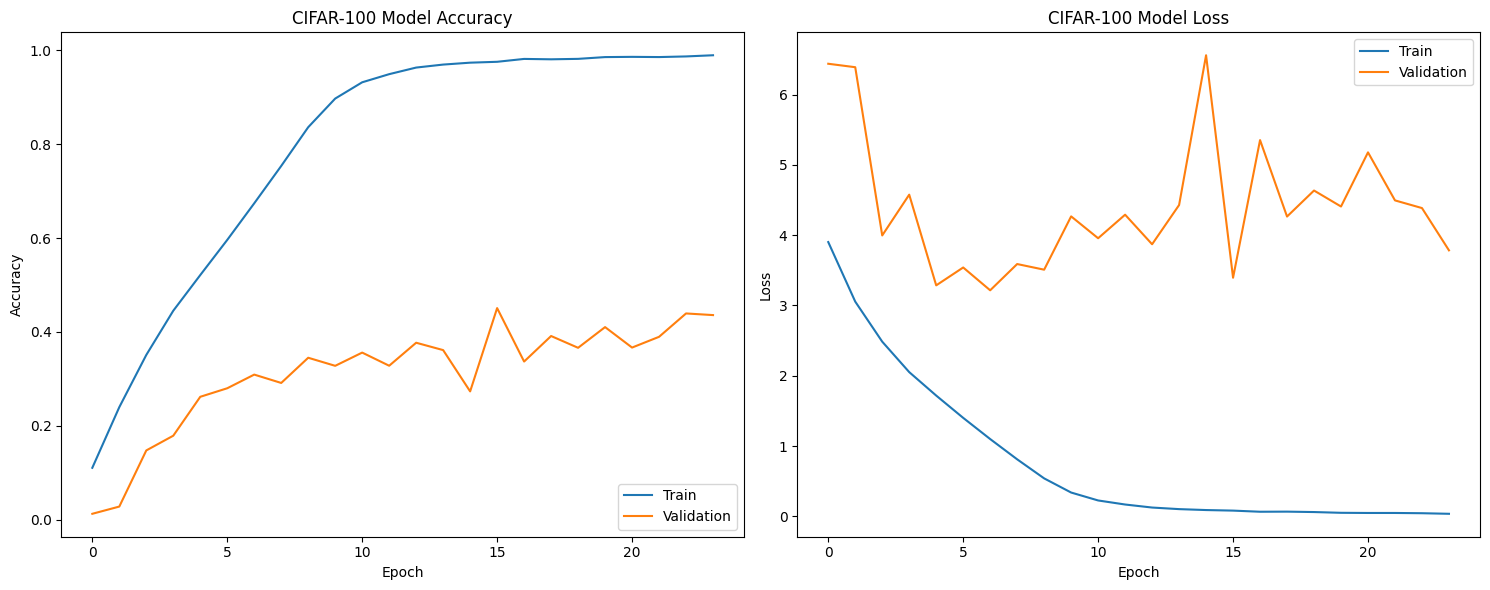

In [ ]:


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CIFAR-100 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CIFAR-100 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:


test_loss, test_accuracy = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


superclass_y_true = np.array([fine_to_coarse_mapping[y] for y in y_true])
superclass_y_pred = np.array([fine_to_coarse_mapping[y] for y in y_pred])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4585 - loss: 3.3802

Test Loss: 3.3930
Test Accuracy: 0.4614
